In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import euclidean, cityblock

plt.style.use('ggplot')
%matplotlib inline

In [23]:
DATASET_1 = 'KeyStrokeDistance.csv'
DATASET_2 = 'keystroke.csv'

In [39]:
df = pd.read_csv(DATASET_1)
subject = df['subject']
df.head()

,subject,key,H,UD,DD
0,rakshith,h,0.110,0.125,0.235
1,rakshith,e,0.094,0.312,0.406
2,rakshith,e,0.062,0.859,0.921
3,rakshith,e,0.078,0.469,0.547
4,rakshith,e,0.062,0.688,0.750


In [25]:
df = pd.read_csv(DATASET_2)
subject = df['subject']
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


In [26]:
class ManhattanDetector:

    def __init__(self, subjects, data):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        self.data = data
    
    def training(self):
        self.mean_vector = self.train.mean().values  
        
    def evaluateSet1(self):
        eers = []
        for subject in self.subjects:
            genuine_user_data = self.data.loc[self.data.subject == subject, "H" : "DD"]
            imposter_data = self.data.loc[self.data.subject != subject, :]
            lengthData = int(len(genuine_user_data)*0.7)
            self.train        = genuine_user_data[:lengthData]
            self.test_genuine = genuine_user_data[lengthData+1:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H":"DD"]
            self.training()
            self.testing()
            labels = [0]*len(self.user_scores) + [1]*len(self.imposter_scores)
            fpr, tpr, thresholds = roc_curve(labels, self.user_scores + self.imposter_scores)
        return fpr, tpr, thresholds
    
    
    def evaluateSet2(self):
        eers = []
        for subject in self.subjects:
            genuine_user_data = self.data.loc[self.data.subject == subject, "H.period":"H.Return"]
            imposter_data = self.data.loc[self.data.subject != subject, :]
            self.train        = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject").head(5).loc[:, "H.period":"H.Return"]
            self.training()
            self.testing()
            labels = [0]*len(self.user_scores) + [1]*len(self.imposter_scores)
            fpr, tpr, thresholds = roc_curve(labels, self.user_scores + self.imposter_scores)
        return fpr, tpr, thresholds
    
    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, self.mean_vector)
            self.user_scores.append(cur_score)

        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, self.mean_vector)
            self.imposter_scores.append(cur_score)


In [27]:
class euclideanDist:
#just the training() function changes, rest all remains same.

    def __init__(self, subjects, data):
        self.user_scores = []
        self.imposter_scores = []
        self.mean_vector = []
        self.subjects = subjects
        self.data = data
        
    def training(self):
        self.mean_vector = self.train.mean().values
        self.std_vector = self.train.std().values
        dropping_indices = []
        for i in range(self.train.shape[0]):
            cur_score = euclidean(self.train.iloc[i].values, 
                                   self.mean_vector)
            if (cur_score > 2*self.std_vector).all() == True:
                dropping_indices.append(i)
        self.train = self.train.drop(self.train.index[dropping_indices])
        self.mean_vector = self.train.mean().values

    def testing(self):
        for i in range(self.test_genuine.shape[0]):
            cur_score = cityblock(self.test_genuine.iloc[i].values, \
                                   self.mean_vector)
            self.user_scores.append(cur_score)
 
        for i in range(self.test_imposter.shape[0]):
            cur_score = cityblock(self.test_imposter.iloc[i].values, \
                                   self.mean_vector)
            self.imposter_scores.append(cur_score)
 
    def evaluateSet1(self):
        eers = []
 
        for subject in self.subjects:        
            genuine_user_data = self.data.loc[self.data.subject == subject, \
                                         "H":"DD"]
            imposter_data = self.data.loc[self.data.subject != subject, :]
            lengthData = int(len(genuine_user_data)*0.7)
            self.train = genuine_user_data[:lengthData]
            self.test_genuine = genuine_user_data[(lengthData)+1:]
            self.test_imposter = imposter_data.groupby("subject"). \
                                 head(5).loc[:, "H":"DD"]
 
            self.training()
            self.testing()
            labels = [0]*len(self.user_scores) + [1]*len(self.imposter_scores)
            fpr, tpr, thresholds = roc_curve(labels, self.user_scores + self.imposter_scores)
        return fpr, tpr, thresholds
            
    def evaluateSet2(self):
        eers = []
 
        for subject in self.subjects:        
            genuine_user_data = self.data.loc[self.data.subject == subject, \
                                         "H.period":"H.Return"]
            imposter_data = self.data.loc[self.data.subject != subject, :]
            
            self.train = genuine_user_data[:200]
            self.test_genuine = genuine_user_data[200:]
            self.test_imposter = imposter_data.groupby("subject"). \
                                 head(5).loc[:, "H.period":"H.Return"]
 
            self.training()
            self.testing()
            labels = [0]*len(self.user_scores) + [1]*len(self.imposter_scores)
            fpr, tpr, thresholds = roc_curve(labels, self.user_scores + self.imposter_scores)
        return fpr, tpr, thresholds

In [28]:
def load_data(file_name, col_to_remove):
    df = pd.read_csv(file_name)

    H_columns  = [col for col in df.columns if col.startswith('H')]
    DD_columns = [col for col in df.columns if col.startswith('DD')]
    UD_columns = [col for col in df.columns if col.startswith('UD')]

    data = {}
    data['total'] = df.drop(columns=col_to_remove)
    data['H']     = df[H_columns]
    data['DD']    = df[DD_columns]
    data['UD']    = df[UD_columns]
    data['pca3']  = pd.DataFrame(PCA(n_components=3).fit_transform(data['total']))
   # data['pca10'] = pd.DataFrame(PCA(n_components=10).fit_transform(data['total']))
    
    return data, df['subject'].values

def calculate_KMeans(data,y):
    X = data['total']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=y)
    n_neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
    parameters = dict(n_neighbors=n_neighbors)
    clf = KNeighborsClassifier()
    grid = GridSearchCV(clf, parameters, cv=5)
    grid.fit(X_train, Y_train)
    results = grid.cv_results_

    Y_pred = grid.predict(X_test)

    fpr, tpr, threshold = roc_curve(Y_test.ravel(), Y_pred.ravel())

    return fpr, tpr, threshold




In [29]:
#getting values for Manhattan distance

data1 = pd.read_csv(DATASET_1)
subjects1 = data1["subject"].unique()
fpr1_1, tpr1_1, thresholds1_1 = ManhattanDetector(subjects1, data1).evaluateSet1()
eer1_1 = brentq(lambda x : 1. - x - interp1d(fpr1_1, tpr1_1)(x), 0., 1.)

data2 = pd.read_csv(DATASET_2)
subjects2 = data2["subject"].unique()
fpr1_2, tpr1_2, thresholds1_2 = ManhattanDetector(subjects2, data2).evaluateSet2()
eer1_2 = brentq(lambda x : 1. - x - interp1d(fpr1_2, tpr1_2)(x), 0., 1.)

In [30]:
#getting values for Euclidean distance

data1 = pd.read_csv(DATASET_1)
subjects1 = data1["subject"].unique()
fpr3_1, tpr3_1, thresholds3_1 = euclideanDist(subjects1, data1).evaluateSet1()
eer3_1 = brentq(lambda x : 1. - x - interp1d(fpr3_1, tpr3_1)(x), 0., 1.)

data2 = pd.read_csv(DATASET_2)
subjects2 = data2["subject"].unique()
fpr3_2, tpr3_2, thresholds3_2 = euclideanDist(subjects2, data2).evaluateSet2()
eer3_2 = brentq(lambda x : 1. - x - interp1d(fpr3_2, tpr3_2)(x), 0., 1.)

In [31]:
#getting values for K-Nearest Neighbours - Data set 1

data1,y1 = load_data(DATASET_1, ['subject', 'key'])
Y = pd.get_dummies(y1).values
fpr2_1, tpr2_1, threshold2_1 = calculate_KMeans(data1,y1)
eer2_1 = brentq(lambda x : 1. - x - interp1d(fpr2_1, tpr2_1)(x), 0., 1.)


In [32]:
#getting values for K-Nearest Neighbours  - Data set 2

data,y = load_data(DATASET_2, ['subject', 'sessionIndex', 'rep'])
Y = pd.get_dummies(y).values
fpr2_2, tpr2_2, threshold2_2 = calculate_KMeans(data,y)
eer2_2 = brentq(lambda x : 1. - x - interp1d(fpr2_2, tpr2_2)(x), 0., 1.)

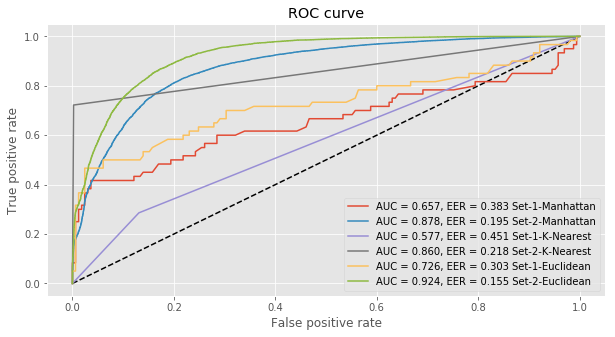

In [33]:
plt.figure(figsize = (10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1_1, tpr1_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-Manhattan'.format(auc(fpr1_1, tpr1_1), eer1_1))
plt.plot(fpr1_2, tpr1_2, label='AUC = {:.3f}, EER = {:.3f} Set-2-Manhattan'.format(auc(fpr1_2, tpr1_2), eer1_2))
plt.plot(fpr2_1, tpr2_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-K-Nearest'.format(auc(fpr2_1, tpr2_1), eer2_1))
plt.plot(fpr2_2, tpr2_2, label='AUC = {:.3f}, EER = {:.3f} Set-2-K-Nearest'.format(auc(fpr2_2, tpr2_2), eer2_2))
plt.plot(fpr3_1, tpr3_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-Euclidean'.format(auc(fpr3_1, tpr3_1), eer3_1))
plt.plot(fpr3_2, tpr3_2, label='AUC = {:.3f}, EER = {:.3f} Set-2-Euclidean'.format(auc(fpr3_2, tpr3_2), eer3_2))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

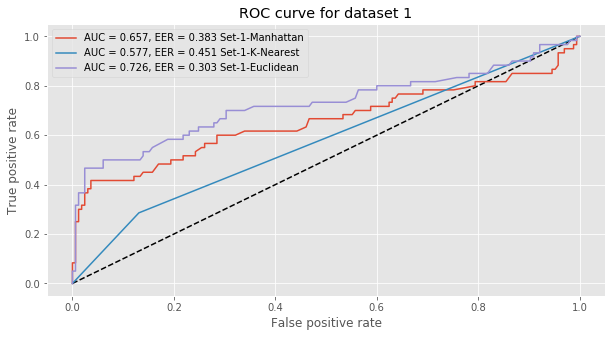

In [34]:
plt.figure(figsize = (10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1_1, tpr1_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-Manhattan'.format(auc(fpr1_1, tpr1_1), eer1_1))
plt.plot(fpr2_1, tpr2_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-K-Nearest'.format(auc(fpr2_1, tpr2_1), eer2_1))
plt.plot(fpr3_1, tpr3_1, label='AUC = {:.3f}, EER = {:.3f} Set-1-Euclidean'.format(auc(fpr3_1, tpr3_1), eer3_1))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for dataset 1')
plt.legend(loc='best')
plt.show()

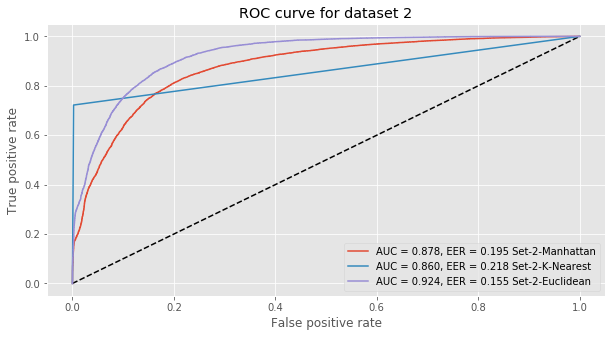

In [35]:
plt.figure(figsize = (10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1_2, tpr1_2, label='AUC = {:.3f}, EER = {:.3f} Set-2-Manhattan'.format(auc(fpr1_2, tpr1_2), eer1_2))
plt.plot(fpr2_2, tpr2_2, label='AUC = {:.3f}, EER = {:.3f} Set-2-K-Nearest'.format(auc(fpr2_2, tpr2_2), eer2_2))
plt.plot(fpr3_2, tpr3_2, label='AUC = {:.3f}, EER = {:.3f} Set-2-Euclidean'.format(auc(fpr3_2, tpr3_2), eer3_2))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for dataset 2')
plt.legend(loc='best')
plt.show()

In [36]:
print("The Datasets for Manhattan distance shows error rates of ", eer1_1, eer1_2)
print("The Datasets for K-Means distance shows error rates of ", eer2_1, eer2_2)
print("The Datasets for Euclidean distance shows error rates of ", eer3_1, eer3_2)

The Datasets for Manhattan distance shows error rates of  0.3833333333333337 0.1947450980392159
The Datasets for K-Means distance shows error rates of  0.4511278195488722 0.21787580694749598
The Datasets for Euclidean distance shows error rates of  0.3030303030310123 0.15539215686329813
